In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Link_Review = pd.read_csv("Cleaned_Link_Review.csv")

In [2]:
from sklearn.model_selection import train_test_split
X_data = Link_Review[['review_content']]
y_data = Link_Review['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = 0.2, 
                                                    random_state=1, 
                                                    stratify = y_data)
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('Train/Test sizes:', y_train.shape[0], y_test.shape[0])

X_train.shape: (36596, 1)
y_train.shape: (36596,)
X_test.shape: (9150, 1)
y_test.shape: (9150,)
Train/Test sizes: 36596 9150


In [3]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
# vectorize X_train and X_test
train_matrix = vec.fit_transform(X_train['review_content'].values.astype('U'))
test_matrix = vec.transform(X_test['review_content'].values.astype('U'))
# vectorize X_train_sub and X_valid
# train_sub_matrix = vec.fit_transform(X_train_sub['review_content'])
# valid_matrix = vec.transform(X_valid['review_content'])

In [4]:
X_train = train_matrix
X_test = test_matrix
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# X_train_sub = train_sub_matrix
# X_valid = valid_matrix
# y_train_sub = y_train_sub.astype('int')
# y_valid = y_valid.astype('int')

# print dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# print(X_train_sub.shape)
# print(y_train_sub.shape)
# print(X_valid.shape)
# print(y_valid.shape)

(36596, 32922)
(36596,)
(9150, 32922)
(9150,)


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [6]:
# RF (grid_search = 150) & LR
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

RF1 = RandomForestClassifier(n_estimators = 150, class_weight = "balanced", random_state = 1, max_depth = None, 
                             criterion = 'entropy')

LR1 = LogisticRegression(max_iter = 10000, random_state = 1)

SC1 = StackingCVClassifier(classifiers=[RF1], 
                            meta_classifier=LR1, 
                            use_probas=True, # changed
                            drop_proba_col='last',
                            #use_features_in_secondary=True,
                            cv=10,
                            random_state=1)

SC1.fit(X_train, y_train)

StackingCVClassifier(classifiers=[RandomForestClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         n_estimators=150,
                                                         random_state=1)],
                     cv=10, drop_proba_col='last',
                     meta_classifier=LogisticRegression(max_iter=10000,
                                                        random_state=1),
                     random_state=1, use_probas=True)

In [7]:
print("Training Accuracy: %0.2f" % SC1.score(X_train, y_train))
print("Test Accuracy: %0.2f" % SC1.score(X_test, y_test))

Training Accuracy: 1.00
Test Accuracy: 0.82


In [8]:
#mean and 95% CI: 
acc_test_SC1 = SC1.score(X_test, y_test)
ci_test_SC1 = 1.96 * np.sqrt((acc_test_SC1*(1-acc_test_SC1)) / y_test.shape[0])

test_SC1_lower = acc_test_SC1-ci_test_SC1
test_SC1_upper = acc_test_SC1+ci_test_SC1

print(test_SC1_lower, test_SC1_upper)

0.8126837221422507 0.8284091740326127


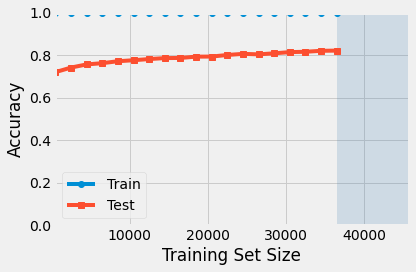

In [9]:
import numpy as np
import matplotlib.pyplot as plt

pred_train, pred_test = [], []

intervals = np.arange(500, X_train.shape[0] + 1, 2000)

for i in intervals:
    SC1.fit(X_train[:i], y_train[:i])
    p_train = SC1.score(X_train[:i], y_train[:i])
    p_test = SC1.score(X_test, y_test)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train.shape[0] + X_test.shape[0]])
    plt.axvspan(X_train.shape[0], 
                X_train.shape[0] + X_test.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.0, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

#OOB Bootstrap on SC1
from mlxtend.evaluate import bootstrap_point632_score
import numpy as np

# Compute Out-of-bag Bootstrap
scores_OOB_SC1 = bootstrap_point632_score(SC1.score, X_train, y_train, method = 'oob', random_seed=1, n_splits=200) # YOUR CODE

# Compute accuracy (average over the bootstrap rounds)
acc_OOB_SC1 = np.mean(scores_OOB_SC1) # YOUR CODE
print('Accuracy: %.2f%%' % (100*acc_OOB_SC1))

# Compute the 95% confidence interval around the accuracy estimate
lower_OOB_SC1 = np.percentile(scores_OOB_SC1, 2.5) # YOUR CODE
upper_OOB_SC1 = np.percentile(scores_OOB_SC1, 97.5)# YOUR CODE
print('95%% Confidence interval: [%.2f, %.2f]' % (lower_OOB_SC1, upper_OOB_SC1))

#.632 Bootstrap on SC1
# Compute .632 Bootstrap
scores_632_SC1 = bootstrap_point632_score(SC1.score, X_train, y_train, method=".632", random_seed=1, n_splits=200)# YOUR CODE


# Compute accuracy (average over the bootstrap rounds)
acc_632_SC1 = np.mean(scores_632_SC1) # YOUR CODE
print('Accuracy: %.2f%%' % (100*acc_632_SC1))

# Compute the 95% confidence interval around the accuracy estimate
lower_632_SC1 = np.percentile(scores_632_SC1, 2.5)# YOUR CODE
upper_632_SC1 = np.percentile(scores_632_SC1, 97.5)# YOUR CODE
print('95%% Confidence interval: [%.2f, %.2f]' % (lower_632_SC1, upper_632_SC1))

In [13]:
#Confusion Matrix of Stacking CV Classifier
from sklearn.preprocessing import StandardScaler
from mlxtend.classifier import StackingCVClassifier
from sklearn.pipeline import make_pipeline

from mlxtend.evaluate import confusion_matrix
#or
#from sklearn.metrics import confusion_matrix

pipe_knn = make_pipeline(StandardScaler(with_mean=False),
                         SC1)

pipe_knn.fit(X_train, y_train)

y_pred = pipe_knn.predict(X_test)

confmat = confusion_matrix(y_test, y_pred)

print(confmat)

[[1496 1124]
 [ 518 6012]]


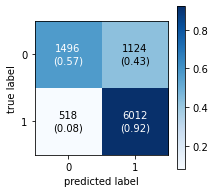

In [14]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt


fig, ax = plot_confusion_matrix(conf_mat=confmat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.show()
#n = 9150

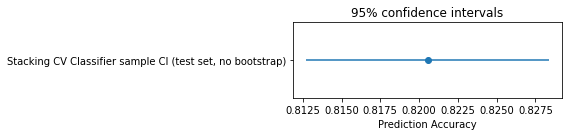

In [16]:
#Summary

labels = [
    "Stacking CV Classifier sample CI (test set, no bootstrap)"
]

mean = [
    acc_test_SC1
]

lower_error = [
    test_SC1_lower
]

upper_error = [
    test_SC1_upper
]


asymmetric_error = [np.array(mean) - np.array(lower_error), 
                    np.array(upper_error) - np.array(mean)]


fig, ax = plt.subplots(figsize=(8, 2))
ax.errorbar(mean, np.arange(len(mean)), xerr=asymmetric_error, fmt='o')
#ax.set_xlim([0.86, 1.0])
ax.set_yticks(np.arange(len(mean)))
ax.set_yticklabels(labels)
ax.set_xlabel('Prediction Accuracy')
ax.set_title('95% confidence intervals')
plt.tight_layout()
plt.savefig('CI_mnist.pdf')
plt.show()